# Recomendation using Collaborative Filtering

is a technique that can filter out items that a user might like on the basis of reactions by similar users. It works by searching a large group of people and finding a smaller set of users with tastes similar to a particular user.

we try to use embedding and also build neural network for a model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import tensorflow as tf
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model


In [2]:
from google.colab import files
uploaded = files.upload()

Saving tourism_rating.csv to tourism_rating.csv
Saving tourism_with_id.csv to tourism_with_id.csv


## upload data

In [4]:
tourism = pd.read_csv('tourism_rating.csv')

In [5]:
tourism.shape

(10000, 3)

In [8]:
tourism.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


## MinMaxScaler Rating ke 0 -1
**MinMaxScaler adalah salah satu jenis scaler dalam pemrosesan data pada machine learning yang digunakan untuk mengubah skala data menjadi dalam rentang nilai tertentu, yaitu 0 hingga 1. Scaler rating jadi 0 sampai 1**

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
tourism['Place_Ratings'] = tourism['Place_Ratings'].values.astype(float)
rating_scaled = pd.DataFrame(scaler.fit_transform(tourism['Place_Ratings'].values.reshape(-1,1)))
tourism['Place_Ratings'] = rating_scaled

In [10]:
tourism['Place_Ratings']

0       0.50
1       0.25
2       1.00
3       0.50
4       0.75
        ... 
9995    0.25
9996    0.75
9997    0.50
9998    0.75
9999    0.25
Name: Place_Ratings, Length: 10000, dtype: float64

## Split data for training 80% and for test 20%

In [11]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(tourism, test_size=0.15, random_state=42)

In [12]:
train.head()

,User_Id,Place_Id,Place_Ratings
8701,262,269,0.50
3429,105,236,0.00
8870,267,236,1.00
6962,209,36,0.75
2088,64,305,0.25


In [13]:
test.head()

,User_Id,Place_Id,Place_Ratings
6252,188,207,0.50
4684,142,268,0.25
1731,54,103,0.50
4742,144,119,0.50
4521,138,288,1.00


In [14]:
jumlah_users = len(tourism.User_Id.unique())
jumlah_users

300

In [15]:
jumlah_tourisms = len(tourism.Place_Id.unique())
jumlah_tourisms

437

## Building Model

In [16]:
# Define input and output features
input_features = ['User_Id', 'Place_Id']
output_feature = 'Place_Ratings'

# Create input tensors
user_input = tf.keras.layers.Input(shape=[1], name="User-Input")
tourism_input = tf.keras.layers.Input(shape=[1], name="Tourism-Input")

# Embed user and tourism IDs
user_embedding = tf.keras.layers.Embedding(input_dim=train['User_Id'].max()+1, output_dim=5, name="User-Embedding")(user_input)
tourism_embedding = tf.keras.layers.Embedding(input_dim=train['Place_Id'].max()+1, output_dim=5, name="Tourism-Embedding")(tourism_input)

# Flatten embeddings
user_vec = tf.keras.layers.Flatten(name="Flatten-Users")(user_embedding)
tourism_vec = tf.keras.layers.Flatten(name="Flatten-Tourism")(tourism_embedding)

# Concatenate embeddings from user vector and tourism vector
concat = tf.keras.layers.Concatenate()([user_vec, tourism_vec])

# Add Fully-Connected layers
# Add dropout layers to avoid overfitting
fc1 = tf.keras.layers.Dense(128, activation='relu')(concat)
dropout1 = tf.keras.layers.Dropout(0.5)(fc1)
fc2 = tf.keras.layers.Dense(64, activation='relu')(dropout1)
dropout2 = tf.keras.layers.Dropout(0.2)(fc2)
fc3 = tf.keras.layers.Dense(16, activation='relu')(dropout2)
dropout3 = tf.keras.layers.Dropout(0.1)(fc3)
output = tf.keras.layers.Dense(1, activation='relu')(dropout3)

# Create model
model = tf.keras.Model(inputs=[user_input, tourism_input], outputs=output)

# Compile model
model.compile(loss='mse', optimizer='adam')

history = model.fit([train['User_Id'], train['Place_Id']], train['Place_Ratings'], 
          epochs=40, batch_size=16)

Epoch 1/40
532/532 [==============================] - 5s 6ms/step - loss: 0.1316
Epoch 2/40
532/532 [==============================] - 2s 5ms/step - loss: 0.1220
Epoch 3/40
532/532 [==============================] - 4s 7ms/step - loss: 0.1176
Epoch 4/40
532/532 [==============================] - 3s 5ms/step - loss: 0.1153
Epoch 5/40
532/532 [==============================] - 4s 8ms/step - loss: 0.1128
Epoch 6/40
532/532 [==============================] - 2s 4ms/step - loss: 0.1091
Epoch 7/40
532/532 [==============================] - 1s 2ms/step - loss: 0.1061
Epoch 8/40
532/532 [==============================] - 1s 2ms/step - loss: 0.1036
Epoch 9/40
532/532 [==============================] - 2s 4ms/step - loss: 0.1004
Epoch 10/40
532/532 [==============================] - 2s 3ms/step - loss: 0.0976
Epoch 11/40
532/532 [==============================] - 1s 2ms/step - loss: 0.0962
Epoch 12/40
532/532 [==============================] - 2s 3ms/step - loss: 0.0928
Epoch 13/40
532/532 [====

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 User-Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Tourism-Input (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 User-Embedding (Embedding)     (None, 1, 5)         1505        ['User-Input[0][0]']             
                                                                                                  
 Tourism-Embedding (Embedding)  (None, 1, 5)         2190        ['Tourism-Input[0][0]']          
                                                                                              

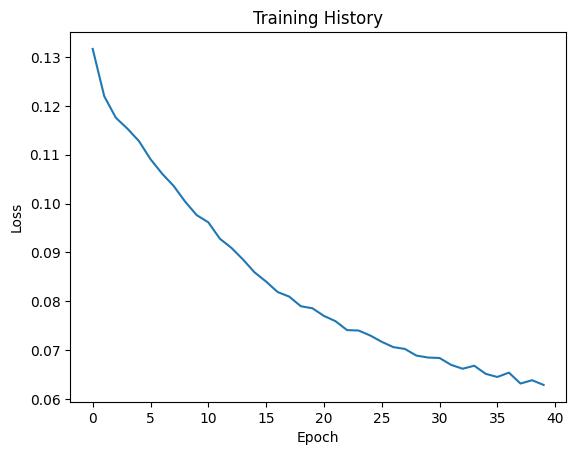

In [18]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [19]:
# Evaluate the model on the test dataset
loss = model.evaluate([test['User_Id'], test['Place_Id']], test['Place_Ratings'], verbose=0)

# Print the mean squared error (MSE)
print("Mean Squared Error:", loss)

#Mean Squared Error: 0.21354129910469055

#Mean Squared Error: [0.19598501920700073, 0.3624797761440277]

#Mean Squared Error: 0.18648888170719147

Mean Squared Error: 0.16547632217407227


In [ ]:
#For Saving model in h5 format
model.save('recommendation_rating_model.h5')

# Prediction Test

In [24]:
# Function to make recommendations for a given user
def make_recommendations(user_id, model, top_k=10):
    # Convert user ID to integer
    user_id = pd.Series([user_id]).astype('category').cat.codes.values[0]
    
    # Create input data for recommendations
    user_data = np.array([user_id] * len(tourism['Place_Id'].unique()))
    tourism_data = np.array(list(tourism['Place_Id'].unique()))
    
    # Make predictions
    predictions = model.predict([user_data, tourism_data]).flatten()
    
    # Get top-k recommendations
    top_indices = predictions.argsort()[-top_k:][::-1]
    top_recommendations = tourism.iloc[top_indices]['Place_Id']
    
    return top_recommendations

# Example usage
user_id = 'ka9qWR2QLJdezf273x8jF9WcOe02'  # Enter the user ID for which you want to make recommendations
top_recommendations = make_recommendations(user_id, model)

# Print the top recommended places
top_recommendations_series = pd.Series(top_recommendations)

top_recommendations_series = pd.DataFrame(top_recommendations, columns=['Place_Id'])

top_recommendations_series

14/14 [==============================] - 0s 2ms/step


,Place_Id
300,341
76,249
232,196
238,30
343,302
302,97
151,219
397,50
226,202
144,301


In [26]:
tempat =pd.read_csv('tourism_with_id.csv')
tempat

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156,NaN,4
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,433,Museum Mpu Tantular,Museum Negeri Mpu Tantular adalah sebuah museu...,Budaya,Surabaya,2000,4.4,45.0,"{'lat': -7.4338593, 'lng': 112.7199058}",-7.433859,112.719906,NaN,433
433,434,Taman Bungkul,Taman Bungkul adalah taman wisata kota yang te...,Taman Hiburan,Surabaya,0,4.6,NaN,"{'lat': -7.291346799999999, 'lng': 112.7398218}",-7.291347,112.739822,NaN,434
434,435,Taman Air Mancur Menari Kenjeran,Air mancur menari atau dancing fountain juga a...,Taman Hiburan,Surabaya,0,4.4,45.0,"{'lat': -7.2752955, 'lng': 112.7549381}",-7.275296,112.754938,NaN,435
435,436,Taman Flora Bratang Surabaya,Taman Flora adalah salah satu taman kota di Su...,Taman Hiburan,Surabaya,0,4.6,NaN,"{'lat': -7.294330299999999, 'lng': 112.7617534}",-7.294330,112.761753,NaN,436


In [27]:
# Convert recommended_tourism_ids to a pandas Series
top_recommendations_series = pd.Series(top_recommendations)

# Filter the rows in tempat that have the same place IDs as recommended_tourism_ids
filtered_tempat = tempat[tempat['Place_Id'].isin(top_recommendations)]

# Print the filtered dataset
filtered_tempat

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
29,30,Taman Menteng,Taman Menteng adalah sebuah taman yang berloka...,Taman Hiburan,Jakarta,0,4.5,NaN,"{'lat': -6.1964087, 'lng': 106.8293106}",-6.196409,106.829311,NaN,30
49,50,Museum Joang 45,Gedung Joang '45 atau Museum Joang 45 adalah s...,Budaya,Jakarta,2000,4.0,NaN,"{'lat': -6.186183799999998, 'lng': 106.8364761}",-6.186184,106.836476,NaN,50
96,97,Monumen Yogya Kembali,Museum Monumen Yogya Kembali (bahasa Jawa: ꦩꦺꦴ...,Budaya,Yogyakarta,15000,4.5,30.0,"{'lat': -7.7495904, 'lng': 110.3696068}",-7.749590,110.369607,NaN,97
195,196,Pantai Ngrenehan,Pantai Ngrenehan merupakan\npantai nelayan. Te...,Bahari,Yogyakarta,3000,4.4,NaN,"{'lat': -8.1211475, 'lng': 110.5142337}",-8.121147,110.514234,NaN,196
201,202,Pantai Ngandong,"Pantai Ngandong terletak di Desa Sidoarjo, Kec...",Bahari,Yogyakarta,10000,4.5,NaN,"{'lat': -8.146423, 'lng': 110.6061408}",-8.146423,110.606141,NaN,202
218,219,Tebing Karaton,Tebing Keraton atau Tebing Karaton merupakan s...,Cagar Alam,Bandung,15000,4.5,NaN,"{'lat': -6.8340683, 'lng': 107.6636151}",-6.834068,107.663615,NaN,219
248,249,Upside Down World Bandung,Upside Down World Bandung pertama kali dibuka ...,Taman Hiburan,Bandung,100000,4.0,30.0,"{'lat': -6.896300000000001, 'lng': 107.617}",-6.896300,107.617000,NaN,249
300,301,Lereng Anteng Panoramic Coffee Place,Lereng Anteng Panoramic Coffee adalah sebuah t...,Cagar Alam,Bandung,50000,4.4,150.0,"{'lat': -6.842535, 'lng': 107.622698}",-6.842535,107.622698,NaN,301
301,302,Masjid Pusdai,Masjid PUSDAI (pusat dakwah islam) dibangun da...,Tempat Ibadah,Bandung,0,4.7,NaN,"{'lat': -6.9000672, 'lng': 107.62587}",-6.900067,107.625870,NaN,302
340,341,Hutan Wisata Tinjomoyo Semarang,Awalnya taman wisata hutan Tinjomoyo Semarang ...,Cagar Alam,Semarang,3000,4.3,NaN,"{'lat': -7.0296837, 'lng': 110.3999611}",-7.029684,110.399961,NaN,341
